In [1]:
import pandas as pd
import numpy as np
import torch
import utils.print as print_f
import os

from utils.engine import evaluate, get_iou_types
from utils.plot import plot_losses, plot_performance
from data.strs import TaskStrs, SourceStrs, FusionStrs

from models.utils import get_model_size_in_MB
from models.build import create_model_from_setup
from models.setup import ModelSetup
from models.train import TrainingInfo
from utils.save import check_best, end_train, get_data_from_metric_logger
from data.load import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.eval import get_performance
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup, get_coco_eval_params, get_dynamic_loss
from utils.init import reproducibility, clean_memory_get_device
from data.paths import MIMIC_EYE_PATH
# from datetime import datetime
# from models.dynamic_loss import DynamicWeightedLoss
from utils.engine import train_one_epoch, evaluate
from torch import optim
from models.setup import ModelSetup
from data.paths import MIMIC_EYE_PATH
# from data.load import seed_worker, get_dataloader_g

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

from models.components.task_performers import ObjectDetectionPerformer
from data.constants import DEFAULT_MIMIC_CLINICAL_NUM_COLS, DEFAULT_MIMIC_CLINICAL_CAT_COLS

%matplotlib inline

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
# 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [3]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [4]:
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [5]:
# fix backbones
common_args = {
    "decoder_channels": [128, 64, 32, 16, 8],
    "optimiser": "sgd",
    "lr": 1e-3,  # 1e-5,  # 1e-3 is a trainable value.
    "batch_size": 4,
    "sgb_momentum": 0.9,
    "weight_decay": 1e-5,  # 1e-5s
    # "pretrained": True,
    "image_size": 512,
    "record_training_performance": False,
    "warmup_epochs": 10,
    "lr_scheduler": "ReduceLROnPlateau",  # ReduceLROnPlateau, MultiStepLR
    "reduceLROnPlateau_factor": 0.5,
    "reduceLROnPlateau_patience": 20,
    "reduceLROnPlateau_full_stop": True,  # set to false to continue run.
    "multiStepLR_milestones": [20, 40, 60, 80, 100],  # list(range(1,100)),
    "multiStepLR_gamma": 0.5,
    "gt_in_train_till": 0,
    "box_head_dropout_rate": 0,
    "model_warmup_epochs": 0,  # stop fixing the weights in the backbone.
    "loss_warmup_epochs": 0,  # should be larger than model warm up.
    "measure_test": True,
    "use_dynamic_weight": True,
    "iou_thrs": np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]),
    "maxDets": [1, 5, 10, 30],
    "normalise_clinical_num": True,
    "use_clinical_df": True, # for nature?
}

bb_to_mask_args = {
    "lesion_detection_use_mask": True,
}

fusion_1D_args = {
    "clinical_lesion_detection_use_1D_fusion": True
}

no_fusion_1D_args = {
    "clinical_lesion_detection_use_1D_fusion": False
}

clinical_deconv_upsample_args = {
    'clinical_upsample': 'deconv'
}

clinical_repeat_upsample_args = {
    'clinical_upsample': 'repeat'
}

clinical_interpolate_upsample_args = {
    'clinical_upsample': 'interpolate'
}

silent_report_args = {"fiaxtions_mode_input": "silent"}

full_report_args = {"fiaxtions_mode_input": "normal"}

reporting_report_args = {"fiaxtions_mode_input": "reporting"}

chexpert_best_args = {
    "performance_standard_task": TaskStrs.CHEXPERT_CLASSIFICATION,
    "performance_standard_metric": "auc",
}

negbio_best_args = {
    "performance_standard_task": TaskStrs.NEGBIO_CLASSIFICATION,
    "performance_standard_metric": "auc",
}

## using froc instead of the AP.
lesion_detection_best_args = {
    "performance_standard_task": TaskStrs.LESION_DETECTION,
    "performance_standard_metric": "froc",
}

lesion_detection_ap_best_args = {
    "performance_standard_task": TaskStrs.LESION_DETECTION,
    "performance_standard_metric": "ap",
}

clinical_best_args = {
    "performance_standard_task": TaskStrs.GENDER_CLASSIFICATION,
    "performance_standard_metric": "accuracy",
}

age_prediction_best_r2 = {
    "performance_standard_task": TaskStrs.AGE_REGRESSION,
    "performance_standard_metric": "r2",
}

clinical_prediction_args = {
    "sources": [SourceStrs.XRAYS],
    "tasks": [
        TaskStrs.AGE_REGRESSION,
        TaskStrs.TEMPERATURE_REGRESSION,
        TaskStrs.HEARTRATE_REGRESSION,
        TaskStrs.RESPRATE_REGRESSION,
        TaskStrs.O2SAT_REGRESSION,
        TaskStrs.SBP_REGRESSION,
        TaskStrs.DBP_REGRESSION,
        TaskStrs.ACUITY_REGRESSION,
        TaskStrs.GENDER_CLASSIFICATION,
    ],
    "fusor": FusionStrs.NO_ACTION,
    "with_clinical_label": True,
}


pos_weight_10_args = {
    "objectness_pos_weight": 10,
}


pos_weight_100_args = {
    "objectness_pos_weight": 100,
}


gender_prediction_args = {
    "sources": [SourceStrs.XRAYS],
    "tasks": [
        TaskStrs.GENDER_CLASSIFICATION,
    ],
    "fusor": FusionStrs.NO_ACTION,
    "with_clinical_label": True,
}

age_prediction_args = {
    "sources": [SourceStrs.XRAYS],
    "tasks": [
        TaskStrs.AGE_REGRESSION,
    ],
    "fusor": FusionStrs.NO_ACTION,
    "with_clinical_label": True,
}

with_fix_args = {
    "sources": [SourceStrs.XRAYS, SourceStrs.FIXATIONS],
    "tasks": [
        TaskStrs.LESION_DETECTION,
    ],
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

lesion_detection_baseline_args = {
    "sources": [SourceStrs.XRAYS],
    "tasks": [
        TaskStrs.LESION_DETECTION,
    ],
}

lesion_detection_with_clinical_args = {
    "sources": [SourceStrs.XRAYS, SourceStrs.CLINICAL],
    "tasks": [
        TaskStrs.LESION_DETECTION,
    ],
}

element_wise_sum_fusor_args= {
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

hadamard_fusor_args = {
    "fusor": FusionStrs.HADAMARD_PRODUCT,
}

concat_fusor_args ={
    "fusor": FusionStrs.CONCAT,
}

concat_block_fusor_args ={
    "fusor": FusionStrs.CONCAT_WITH_BLOCK,
}

concat_token_mixer_fusor_args = {
    "fusor": FusionStrs.CONCAT_WITH_TOKENMIXER,
}

concat_block_token_mixer_fusor_args = {
    "fusor": FusionStrs.CONCAT_WITH_BLOCK_TOKENMIXER,
}

with_fix_chexpert_args = {
    "sources": [SourceStrs.XRAYS, SourceStrs.FIXATIONS],
    "tasks": [
        TaskStrs.CHEXPERT_CLASSIFICATION,
    ],
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

without_fix_chexpert_args = {
    "sources": [SourceStrs.XRAYS],
    "tasks": [
        TaskStrs.CHEXPERT_CLASSIFICATION,
    ],
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

with_fix_negbio_args = {
    "sources": [SourceStrs.XRAYS, SourceStrs.FIXATIONS],
    "tasks": [
        TaskStrs.NEGBIO_CLASSIFICATION,
    ],
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

without_fix_negbio_args = {
    "sources": [SourceStrs.XRAYS],
    "tasks": [
        TaskStrs.NEGBIO_CLASSIFICATION,
    ],
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

clinical_expander_args = {
    "clinical_use_expander": True,
}

small_model_args = {
    "mask_hidden_layers": 64,
    "fuse_conv_channels": 64,
    "representation_size": 64,  # 32
    # "clinical_input_channels": 64,
    # "clinical_conv_channels": 64,
    # "clinical_expand_conv_channels": 64,
    "backbone_out_channels": 64,
}

mobilenet_args = {
    "backbone": "mobilenet_v3",
    "using_fpn": False,
}

resnet18_args = {
    "backbone": "resnet18",
    "using_fpn": False,
}

densenet_args = {
    "backbone": "densenet161",
    "using_fpn": False,
}

efficientnet_b0_args = {
    "backbone": "efficientnet_b0",
    "using_fpn": False,
}

efficientnet_b5_args = {
    "backbone": "efficientnet_b5",
    "using_fpn": False,
}

vgg16_args = {
    "backbone": "vgg16",
    "using_fpn": False,
}

regnet_y_8gf_args = {
    "backbone": "regnet_y_8gf",
    "using_fpn": False,
}

convnext_base_args = {
    "backbone": "convnext_base",
    "using_fpn": False,
}

resnet50_args = {
    "backbone": "resnet50",
    "using_fpn": False,
}

# "sources": [SourceStrs.XRAYS, SourceStrs.CLINICAL,],
# "tasks": [
#     # TaskStrs.LESION_DETECTION,
#     TaskStrs.FIXATION_GENERATION,
#     TaskStrs.CHEXPERT_CLASSIFICATION,
#     TaskStrs.NEGBIO_CLASSIFICATION,
# ],
# "performance_standard_task": TaskStrs.CHEXPERT_CLASSIFICATION,
# "performance_standard_metric": "auc",
# "performance_standard_task": TaskStrs.LESION_DETECTION,
# "performance_standard_metric": "ap",


In [6]:
# model.fusor

In [7]:
all_model_setups = [
    ## Retrained with AP
    ModelSetup(
        name="clinical_convnext_base_sum",
        **lesion_detection_ap_best_args,
        **convnext_base_args,
        **small_model_args,
        **common_args,
        **bb_to_mask_args,
        ## multi-modal
        **lesion_detection_with_clinical_args,
        **clinical_deconv_upsample_args,
        **element_wise_sum_fusor_args,
        **no_fusion_1D_args,
    ),

    ModelSetup(
        name="clinical_convnext_base_product",
        **lesion_detection_ap_best_args,
        **convnext_base_args,
        **small_model_args,
        **common_args,
        **bb_to_mask_args,
        ## multi-modal
        **lesion_detection_with_clinical_args,
        **clinical_deconv_upsample_args,
        **hadamard_fusor_args,
        **no_fusion_1D_args,
    ),

    ModelSetup(
        name="clinical_convnext_base_concat",
        **lesion_detection_ap_best_args,
        **convnext_base_args,
        **small_model_args,
        **common_args,
        **bb_to_mask_args,
        ## multi-modal
        **lesion_detection_with_clinical_args,
        **clinical_deconv_upsample_args,
        **concat_fusor_args,
        **no_fusion_1D_args,
    ),

    ModelSetup(
        name="clinical_convnext_base_concat_b",
        **lesion_detection_ap_best_args,
        **convnext_base_args,
        **small_model_args,
        **common_args,
        **bb_to_mask_args,
        ## multi-modal
        **lesion_detection_with_clinical_args,
        **clinical_deconv_upsample_args,
        **concat_block_fusor_args,
        **no_fusion_1D_args,
    ),

    ModelSetup(
        name="clinical_convnext_base_tm",
        **lesion_detection_ap_best_args,
        **convnext_base_args,
        **small_model_args,
        **common_args,
        **bb_to_mask_args,
        ## multi-modal
        **lesion_detection_with_clinical_args,
        **clinical_deconv_upsample_args,
        **concat_token_mixer_fusor_args,
        **no_fusion_1D_args,
    ),

    ModelSetup(
        name="clinical_convnext_base_tm_b",
        **lesion_detection_ap_best_args,
        **convnext_base_args,
        **small_model_args,
        **common_args,
        **bb_to_mask_args,
        ## multi-modal
        **lesion_detection_with_clinical_args,
        **clinical_deconv_upsample_args,
        **concat_block_token_mixer_fusor_args,
        **no_fusion_1D_args,
    ),

    ## TO TRAIN
    # ModelSetup(
    #     name="clinical_convnext_base",
    #     **lesion_detection_ap_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **bb_to_mask_args,
    #     ## multi-modal
    #     **lesion_detection_with_clinical_args,
    #     **clinical_interpolate_upsample_args,
    #     **element_wise_sum_fusor_args,
    #     **no_fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="clinical_convnext_base",
    #     **lesion_detection_ap_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **bb_to_mask_args,
    #     ## multi-modal
    #     **lesion_detection_with_clinical_args,
    #     **clinical_interpolate_upsample_args,
    #     **element_wise_sum_fusor_args,
    #     **no_fusion_1D_args,
    # ),

    # RECORDS
    # ModelSetup(
    #     name="baseline_convnext_base",
    #     **lesion_detection_ap_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **bb_to_mask_args,
    #     **lesion_detection_baseline_args,
    # ),
    # ModelSetup(
    #     name="clinical_densenet_3D",
    #     **lesion_detection_ap_best_args,
    #     **densenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **bb_to_mask_args,
    #     ## multi-modal
    #     **no_fusion_1D_args,
    #     **element_wise_sum_fusor_args,
    #     **lesion_detection_with_clinical_args,
    # ),
    # ModelSetup(
    #     name="clinical_densenet_1D_3D",
    #     **lesion_detection_ap_best_args,
    #     **densenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **bb_to_mask_args,
    #     ## multi-modal
    #     **fusion_1D_args,
    #     **element_wise_sum_fusor_args,
    #     **lesion_detection_with_clinical_args,
    # ),
    # ModelSetup(
    #     name="baseline_densenet",
    #     **lesion_detection_ap_best_args,
    #     **densenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **bb_to_mask_args,
    #     **lesion_detection_baseline_args,
    # ),
    ##### Records
    # ModelSetup(
    #     name="lesion_dsetection_baseline_mobilenet",
    #     **lesion_detection_best_args,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_baseline_args,
    #     **bb_to_mask_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_mobilenet",
    #     **lesion_detection_best_args,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_mobilenet",
    #     **lesion_detection_best_args,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_baseline_resnet18",
    #     **lesion_detection_best_args,
    #     **resnet18_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_baseline_args,
    #     **bb_to_mask_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_resnet18_1D_3D",
    #     **lesion_detection_best_args,
    #     **resnet18_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_resnet18_3D",
    #     **lesion_detection_best_args,
    #     **resnet18_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_convnext_base_3D",
    #     **lesion_detection_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_convnext_base_1D_3D",
    #     **lesion_detection_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_baseline_convnext_base",
    #     **lesion_detection_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_baseline_args,
    #     **bb_to_mask_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_baseline_efficientnet_b0",
    #     **lesion_detection_best_args,
    #     **efficientnet_b0_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_baseline_args,
    #     **bb_to_mask_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_efficientnet_b0_1D_3D",
    #     **lesion_detection_best_args,
    #     **efficientnet_b0_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_efficientnet_b0_3D",
    #     **lesion_detection_best_args,
    #     **efficientnet_b0_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_baseline_densenet",
    #     **lesion_detection_best_args,
    #     **densenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_baseline_args,
    #     **bb_to_mask_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_densenet_1D_3D",
    #     **lesion_detection_best_args,
    #     **densenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_densenet_3D",
    #     **lesion_detection_best_args,
    #     **densenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    # ),
    #  ModelSetup(
    #     name="lesion_dsetection_baseline_resnet50",
    #     **lesion_detection_best_args,
    #     **resnet50_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_baseline_args,
    #     **bb_to_mask_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_resnet50_1D_3D",
    #     **lesion_detection_best_args,
    #     **resnet50_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_resnet50_3D",
    #     **lesion_detection_best_args,
    #     **resnet50_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_baseline_efficientnet_b5",
    #     **lesion_detection_best_args,
    #     **efficientnet_b5_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_baseline_args,
    #     **bb_to_mask_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_efficientnet_b5_1D_3D",
    #     **lesion_detection_best_args,
    #     **efficientnet_b5_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_efficientnet_b5_3D",
    #     **lesion_detection_best_args,
    #     **efficientnet_b5_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_convnext_base_3D_cocat_token_mixer",
    #     **lesion_detection_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_concat_with_token_mixer_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_convnext_base_3D_hadamard",
    #     **lesion_detection_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_hadmard_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    # ),
    ### also test out the tabular data expander.
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_expander_convnext_base_3D_cocat",
    #     **lesion_detection_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_concat_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    #     **clinical_expander_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_convnext_base_3D_cocat",
    #     **lesion_detection_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_concat_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    # ),
    ### prepare to train
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer",
    #     **lesion_detection_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_concat_with_norm_act_token_mixer_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    # ),
    # test out pos_weight for loss term of objectness_loss
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10",
    #     **lesion_detection_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_concat_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    #     **pos_weight_10_args,
    # ),
    # ModelSetup(
    #     name="lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_100",
    #     **lesion_detection_best_args,
    #     **convnext_base_args,
    #     **small_model_args,
    #     **common_args,
    #     **lesion_detection_with_clinical_concat_args,
    #     **bb_to_mask_args,
    #     **no_fusion_1D_args,
    #     **pos_weight_100_args,
    # ),
    ### to train.
    ## if it doesn't work, we use AP and do it again.
    # ModelSetup(
    #     name="lesion_dsetection_with_fix_mobilenet",
    #     **lesion_detection_best_args,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **with_fix_args,
    #     **reporting_report_args,  # see if disabling this will get more time.
    # ),
]

# pick the best one.


In [8]:
num_epochs = 200
train_infos: list[TrainingInfo] = []

In [9]:
# we have to mention that in order to provide objective evaluation, we compromise the dataset size, which also nagatively afftect the performance and generlaization.
for setup in all_model_setups:
    
    device = clean_memory_get_device()
    reproducibility()

    assert (
        len(setup.sources) > 0 and len(setup.tasks) > 0
    ), "Need at least one source and task."

    print_f.print_title("Preparing for the training.")

    train_info = TrainingInfo(setup)

    model = create_model_from_setup(setup=setup)
    model = model.to(device)

    if "lesion-detection" in model.task_performers: 
        model.task_performers["lesion-detection"].roi_heads.score_thresh = 0   
     
    train_info.all_tasks = list(model.task_performers.keys())
    print(f" Model Size [{get_model_size_in_MB(model):.3f}] MB")

    ################ Datasets ################
    dataset_params_dict = {
        "MIMIC_EYE_PATH": MIMIC_EYE_PATH,
        "labels_cols": setup.lesion_label_cols,
        "with_xrays_input": SourceStrs.XRAYS in setup.sources,
        "with_clincal_input": SourceStrs.CLINICAL in setup.sources,
        "with_fixations_input": SourceStrs.FIXATIONS in setup.sources,
        "fixations_mode_input": setup.fiaxtions_mode_input,
        "with_bboxes_label": TaskStrs.LESION_DETECTION in setup.tasks,
        "with_fixations_label": TaskStrs.FIXATION_GENERATION in setup.tasks,
        "fixations_mode_label": setup.fiaxtions_mode_label,
        "with_chexpert_label": TaskStrs.CHEXPERT_CLASSIFICATION in setup.tasks,
        "with_negbio_label": TaskStrs.NEGBIO_CLASSIFICATION in setup.tasks,
        "clinical_numerical_cols": setup.clinical_num,
        "clinical_categorical_cols": setup.clinical_cat,
        "image_size": setup.image_size,
        "image_mean": setup.image_mean,
        "image_std": setup.image_std,
        "with_clinical_label": setup.with_clinical_label,
        "normalise_clinical_num": setup.normalise_clinical_num,
        "bbox_to_mask": setup.lesion_detection_use_mask, 
        "use_clinical_df":setup.use_clinical_df,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        test_dataset,
        batch_size=setup.batch_size,
    )

    train_coco = None
    val_coco = None
    test_coco = None
    eval_params_dict = None

    if TaskStrs.LESION_DETECTION in setup.tasks:
        train_coco, val_coco, test_coco, eval_params_dict = get_coco_eval_params(
            source_name=SourceStrs.XRAYS,
            task_name=TaskStrs.LESION_DETECTION,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            detect_eval_dataset=detect_eval_dataset,
            iou_thrs=setup.iou_thrs,
            use_iobb=setup.use_iobb,
            maxDets=setup.maxDets,
        )

    train_info.timer.start_training()

    dynamic_loss_weight = None
    if setup.use_dynamic_weight:
        dynamic_loss_weight = get_dynamic_loss(
            loss_keys=model.get_all_losses_keys(), device=device
        )

    params = model.get_all_params(dynamic_loss_weight=dynamic_loss_weight)

    iou_types = get_iou_types(model, setup)
    optimizer = get_optimiser(params, setup)
    lr_scheduler = get_lr_scheduler(optimizer, setup)

    print_f.print_title(
        f"Start training. Preparing Took [{train_info.timer.has_took_sec_from_init()}] sec"
    )

    train_info.timer.start_training()

    val_loss = None

    # Start the training from here.
    for e in range(1, num_epochs + 1):
        trained_model_prt = ("="*30) + "Trained Models" + ("="*30)
        print(trained_model_prt)
        for train_info in train_infos :
            print(train_info.best_performance_model_path)
        print(("="*len(trained_model_prt)))
        

        print_f.print_title(f"Training model: [{setup.name}]")

        print(train_info)
        if dynamic_loss_weight:
            for k, v in dynamic_loss_weight.params.items():
                print(f"[{k}]: {v.item():.4f}")

        train_info.epoch = e

        train_info.timer.start_epoch()

        if (
            any(
                [
                    isinstance(p, ObjectDetectionPerformer)
                    for p in model.task_performers.values()
                ]
            )
            and train_info.epoch > setup.gt_in_train_till
        ):
            model.task_performers[
                TaskStrs.LESION_DETECTION
            ].roi_heads.use_gt_in_train = False

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = train_one_epoch(
            setup=setup,
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            # data_loader=test_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
            dynamic_loss_weight=dynamic_loss_weight,
            return_dt_gt=True,
        )

        train_info.train_losses.append(get_data_from_metric_logger(train_loger))
        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()


        train_info.last_val_evaluator, val_logger = evaluate(
            setup=setup,
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            return_dt_gt=True,
        )

        train_info.val_losses.append(get_data_from_metric_logger(val_logger))

        train_info.performance["train"].append(
            get_performance(
                train_dataset,
                train_info.all_tasks,
                train_info.last_train_evaluator,
                iouThr=None,
                areaRng="all",
                maxDets=30,
            )
        )

        train_info.performance["val"].append(
            get_performance(
                val_dataset,
                train_info.all_tasks,
                train_info.last_val_evaluator,
                iouThr=None,
                areaRng="all",
                maxDets=30,
            )
        )

        test_performance = None
        if setup.measure_test:  
            train_info.test_evaluator, test_logger = evaluate(
                setup=setup,
                model=model,
                data_loader=test_dataloader,
                device=device,
                params_dict=eval_params_dict,
                coco=test_coco,
                iou_types=iou_types,
                return_dt_gt=True,
            )
            train_info.test_losses.append(get_data_from_metric_logger(test_logger))

            test_performance = get_performance(
                test_dataset,
                train_info.all_tasks,
                train_info.test_evaluator,
            )
            train_info.performance["test"].append(test_performance)

        # update the learning rate

        # use Average Precision (Performance value) instead of loss in lr_scheduler.
        # val_loss = train_info.val_losses[-1]["loss"]
        val_performance_value = train_info.performance["val"][-1][
            setup.performance_standard_task
        ][setup.performance_standard_metric]

        epoch_took, sec_already_took, speed = train_info.timer.end_epoch(
            train_info.epoch
        )

        if train_info.epoch > setup.warmup_epochs:
            if not lr_scheduler is None:
                if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    if (
                        setup.reduceLROnPlateau_full_stop
                        and lr_scheduler.num_bad_epochs
                        >= setup.reduceLROnPlateau_patience
                    ):
                        print_f.print_title(
                            f"| EarlyStop | Epoch [{train_info.epoch}] Done | It has took [{sec_already_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
                        )
                        break
                    lr_scheduler.step(val_performance_value)
                else:
                    lr_scheduler.step()

        # Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        # plot all matrics
        plot_performance(
            performance=train_info.performance,
            all_tasks=train_info.all_tasks,
            fig_title="Performance",
        )

        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
            test_logers=train_info.test_losses,
        )

        print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_already_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

        if lr_scheduler and hasattr(lr_scheduler, "num_bad_epochs"):
            print_str += f"Patience [{lr_scheduler.num_bad_epochs}] |"

        print_f.print_title(print_str)

        #######################################################################################
        # ignore the first 10 epoch, since the training is still warming up.
        if train_info.epoch > setup.warmup_epochs and setup.save_early_stop_model:
            val_performance_value, train_info = check_best(
                setup=setup,
                val_performance_value=train_info.performance["val"][-1][
                    setup.performance_standard_task
                ][setup.performance_standard_metric],
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                dynamic_weight=dynamic_loss_weight,
                test_performance=test_performance,
            )

    train_info = end_train(
        setup=setup,
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_performance=train_info.performance["val"][-1][
            setup.performance_standard_task
        ][setup.performance_standard_metric],
        test_dataloader=test_dataloader,
        device=device,
        test_coco=test_coco,
        iou_types=iou_types,
        dynamic_weight=dynamic_loss_weight,
        test_performance = test_performance,
    )

    train_infos.append(train_info)

# TODO: allow for any kind of pipeline.
## bb is not resizeda
# 0.02
# 1645m 53.7s

# how to evaluate the model? print some values out.


This notebook will running on device: [CUDA]
====================Preparing for the training.====================


In [ ]:
# what's the best training method, AP or FROC? => Go FROC
# what's the best model?
# what's the best fusion method?
# what's the best upsampling mechanic

torch.Size([1177, 4])

In [ ]:
model.task_performers['lesion-detection'].roi_heads.box_features.shape

torch.Size([2048, 64, 7, 7])

========================================For Training [clinical_densenet_3D]========================================
ModelSetup(get_performance_iou=None, get_performance_areaRng='all', name='clinical_densenet_3D', sources=['xrays', 'clinical'], tasks=['lesion-detection'], fusor='element-wise sum', decoder_channels=[128, 64, 32, 16, 8], lesion_label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, normalise_clinical_num=True, record_training_performance=False, backbone='densenet161', optimiser='sgd', lr=0.001, weight_decay=1e-05, sgb_momentum=0.9, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=512, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225], backbone_out_channels=64, batch_size=4, warmup_epochs=10, model_warmup_epochs=0, loss_warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.5, reduceLROnPlateau_patience=20, reduceLRO

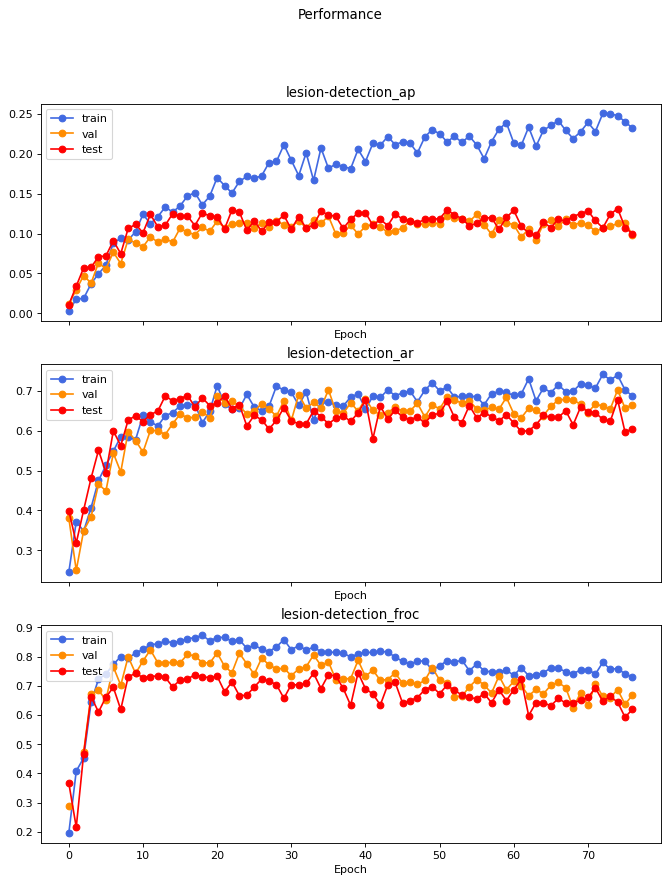

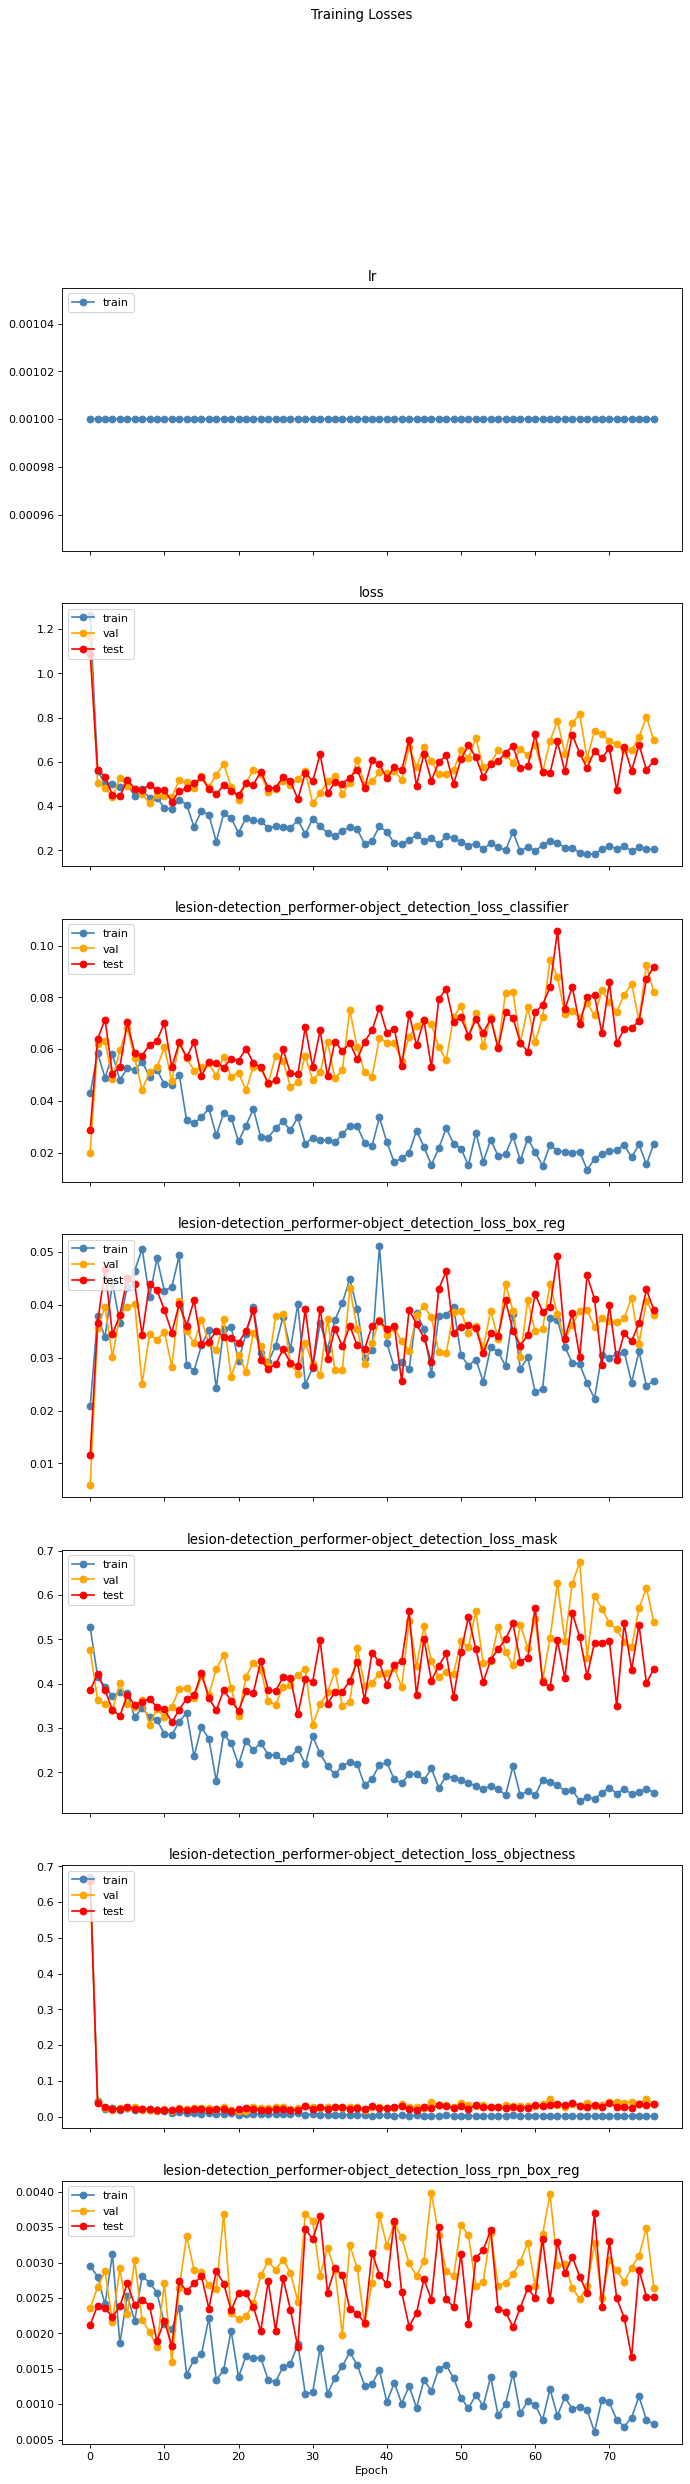

========================================For Training [clinical_densenet_1D_3D]========================================
ModelSetup(get_performance_iou=None, get_performance_areaRng='all', name='clinical_densenet_1D_3D', sources=['xrays', 'clinical'], tasks=['lesion-detection'], fusor='element-wise sum', decoder_channels=[128, 64, 32, 16, 8], lesion_label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, normalise_clinical_num=True, record_training_performance=False, backbone='densenet161', optimiser='sgd', lr=0.001, weight_decay=1e-05, sgb_momentum=0.9, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=512, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225], backbone_out_channels=64, batch_size=4, warmup_epochs=10, model_warmup_epochs=0, loss_warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.5, reduceLROnPlateau_patience=20, red

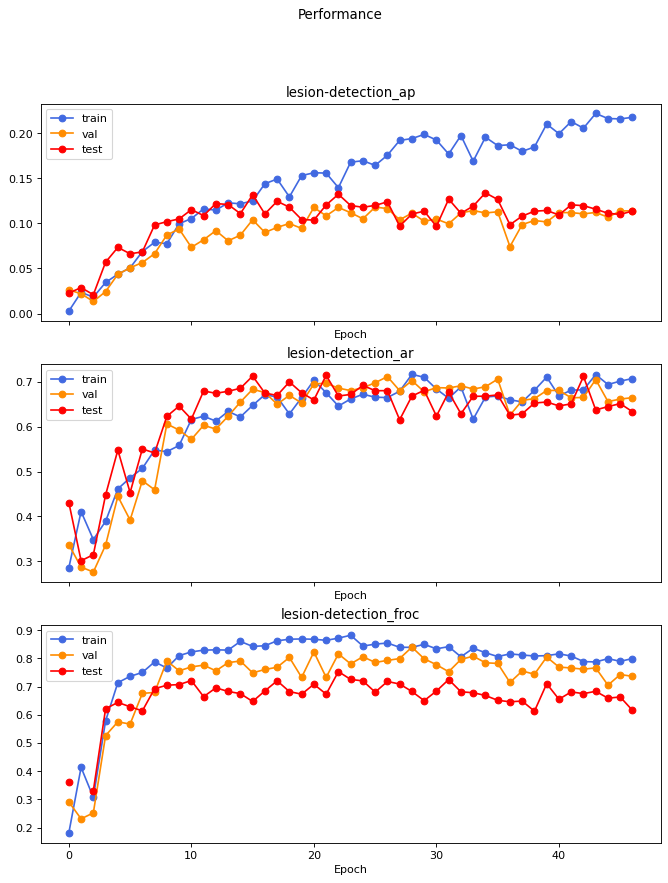

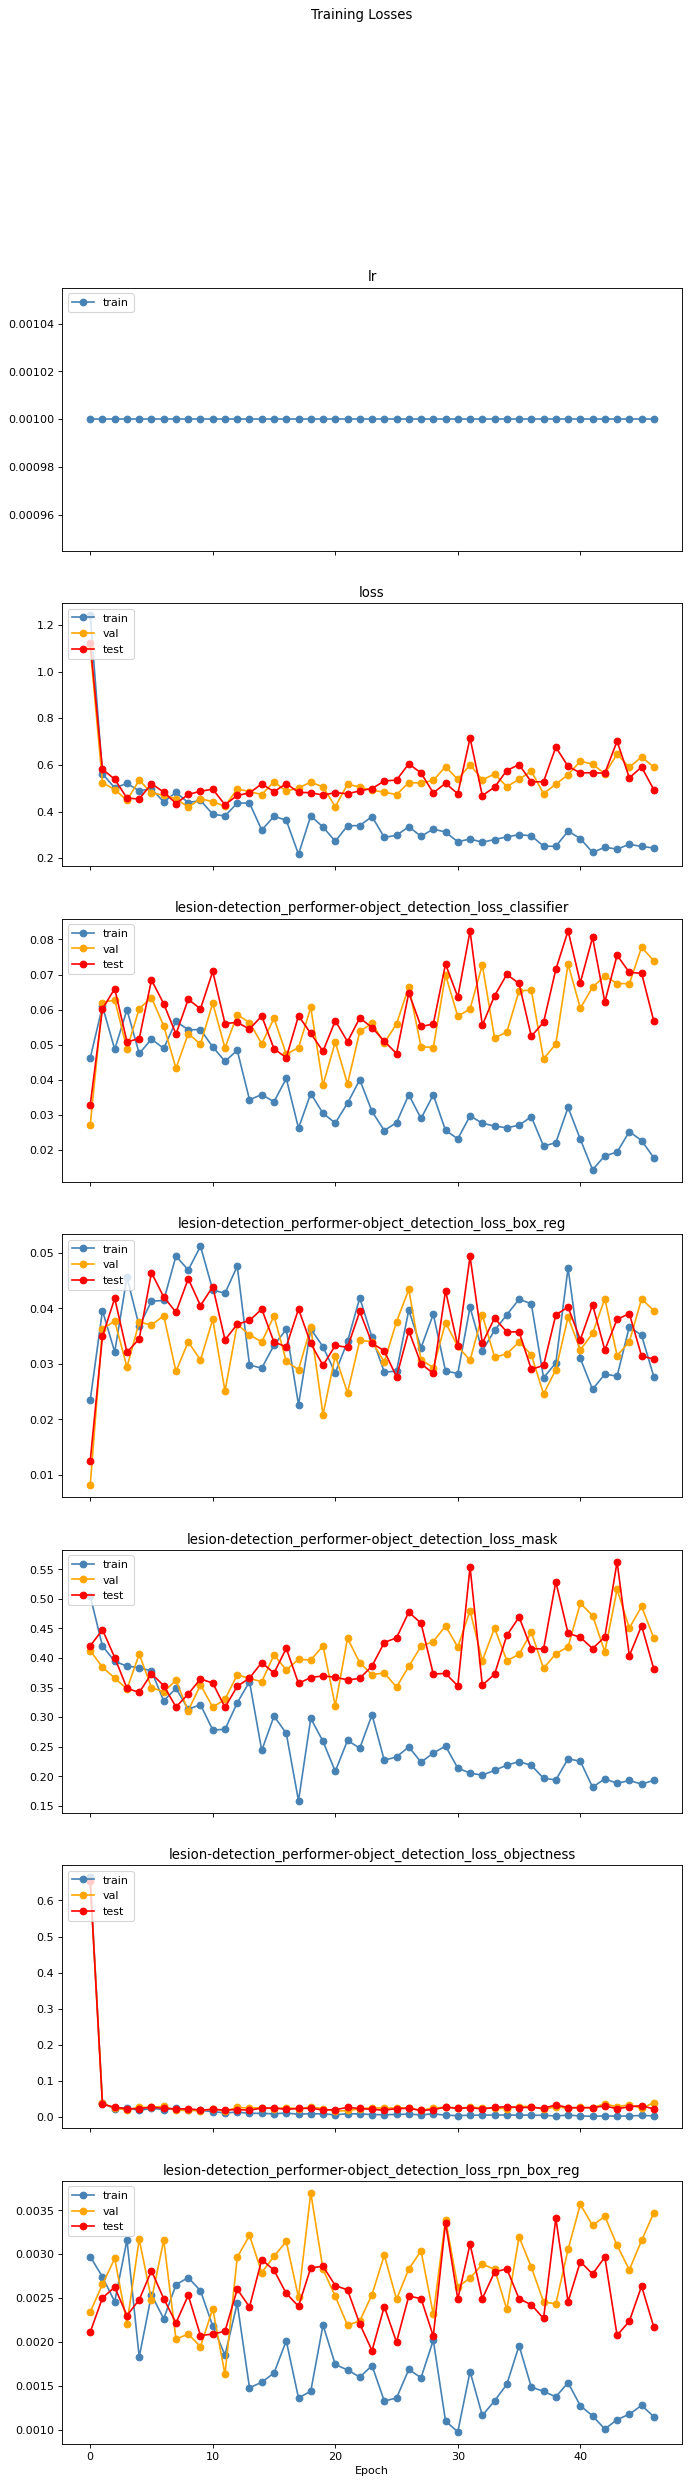

========================================For Training [baseline_densenet]========================================
ModelSetup(get_performance_iou=None, get_performance_areaRng='all', name='baseline_densenet', sources=['xrays'], tasks=['lesion-detection'], fusor='element-wise sum', decoder_channels=[128, 64, 32, 16, 8], lesion_label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, normalise_clinical_num=True, record_training_performance=False, backbone='densenet161', optimiser='sgd', lr=0.001, weight_decay=1e-05, sgb_momentum=0.9, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=512, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225], backbone_out_channels=64, batch_size=4, warmup_epochs=10, model_warmup_epochs=0, loss_warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.5, reduceLROnPlateau_patience=20, reduceLROnPlateau_full_stop

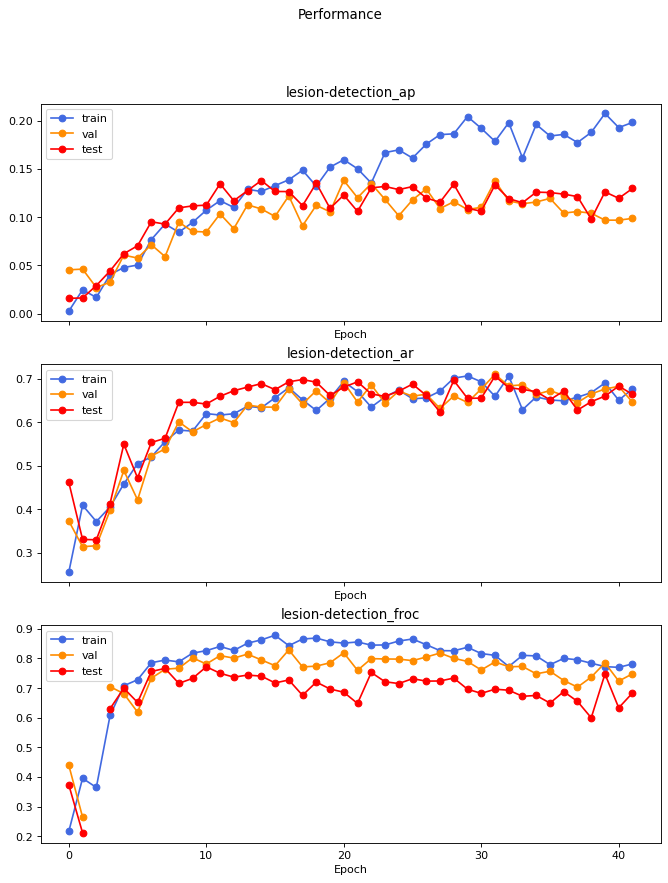

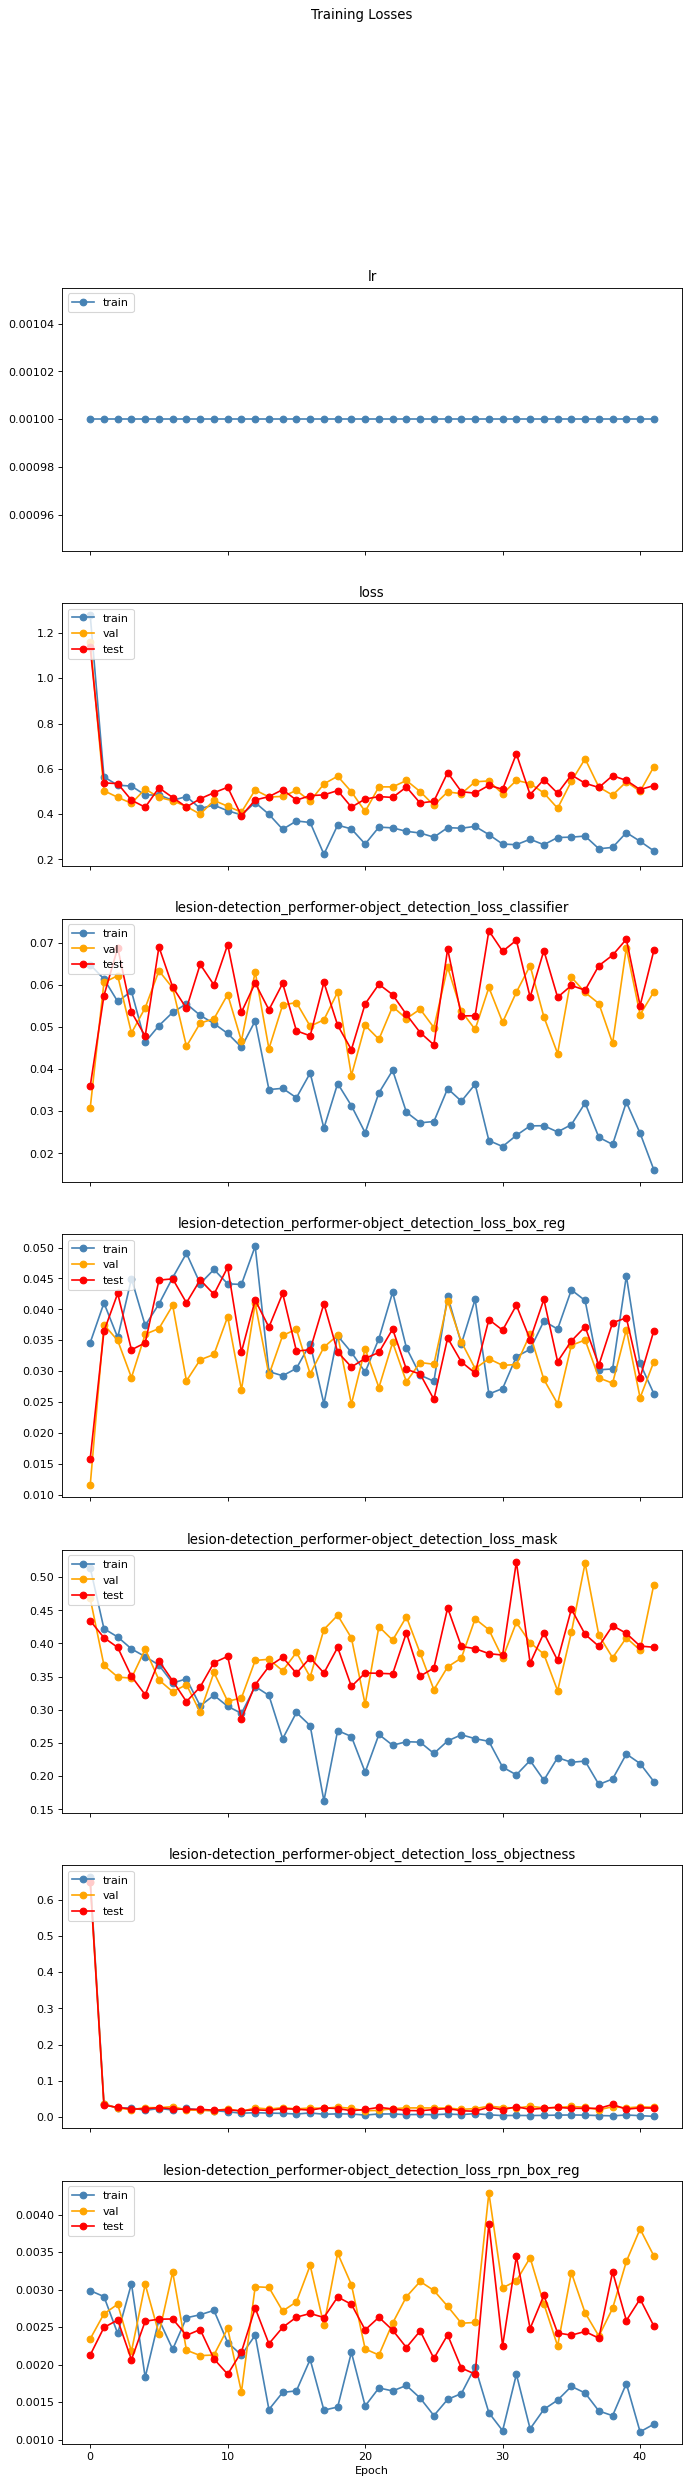

In [ ]:
for train_info in train_infos :
    print(train_info)
    plot_performance(
        performance=train_info.performance,
        all_tasks=train_info.all_tasks,
        fig_title="Performance",
    )
    plot_losses(
        train_info.train_losses,
        train_info.val_losses,
        test_logers=train_info.test_losses,
    )

In [ ]:
for train_info in train_infos :
    print(train_info.best_performance_model_path)

val_lesion-detection_ap_0_1240_test_lesion-detection_ap_0_1129_epoch56_05-15-2023 13-04-42_clinical_densenet_3D
val_lesion-detection_ap_0_1182_test_lesion-detection_ap_0_1200_epoch26_05-15-2023 16-25-55_clinical_densenet_1D_3D
val_lesion-detection_ap_0_1382_test_lesion-detection_ap_0_1230_epoch21_05-15-2023 18-19-01_baseline_densenet


In [ ]:
# for train_info in train_infos :
#     print(train_info.final_model_path)

In [ ]:
# the baseline model is too great.

# val_lesion-detection_froc_0_8214_test_lesion-detection_froc_0_7215_epoch29_05-08-2023 03-29-15_lesion_dsetection_baseline_mobilenet
# val_lesion-detection_froc_0_7802_test_lesion-detection_froc_0_7193_epoch27_05-08-2023 04-57-59_lesion_dsetection_with_clinical_mobilenet  # (1D+3D)
# val_lesion-detection_froc_0_8345_test_lesion-detection_froc_0_7381_epoch31_05-08-2023 08-28-01_lesion_dsetection_with_clinical_mobilenet  # (3D only)

# val_lesion-detection_froc_0_8262_test_lesion-detection_froc_0_7828_epoch21_05-08-2023 10-52-48_lesion_dsetection_baseline_resnet18
# val_lesion-detection_froc_0_8063_test_lesion-detection_froc_0_7156_epoch21_05-08-2023 17-24-35_lesion_dsetection_with_clinical_resnet18 # (1D+3D)
# val_lesion-detection_froc_0_8391_test_lesion-detection_froc_0_7007_epoch51_05-09-2023 00-03-18_lesion_dsetection_with_clinical_resnet18 # (3D only)

# val_lesion-detection_froc_0_8422_test_lesion-detection_froc_0_7991_epoch39_05-09-2023 03-20-36_lesion_dsetection_baseline_convnext_base
# val_lesion-detection_froc_0_8248_test_lesion-detection_froc_0_7867_epoch45_05-09-2023 07-31-28_lesion_dsetection_with_clinical_convnext_base_1D_3D
# val_lesion-detection_froc_0_8104_test_lesion-detection_froc_0_7584_epoch62_05-09-2023 12-56-34_lesion_dsetection_with_clinical_convnext_base_3D

# val_lesion-detection_froc_0_8148_test_lesion-detection_froc_0_7649_epoch39_05-09-2023 17-27-41_lesion_dsetection_with_clinical_convnext_base_3D
# val_lesion-detection_froc_0_8409_test_lesion-detection_froc_0_8003_epoch29_05-09-2023 19-09-54_lesion_dsetection_with_clinical_convnext_base_1D_3D
# val_lesion-detection_froc_0_8597_test_lesion-detection_froc_0_8035_epoch41_05-09-2023 21-40-22_lesion_dsetection_baseline_convnext_base

# val_lesion-detection_froc_0_8301_test_lesion-detection_froc_0_7479_epoch23_05-09-2023 23-23-11_lesion_dsetection_baseline_efficientnet_b0
# val_lesion-detection_froc_0_7876_test_lesion-detection_froc_0_7051_epoch35_05-10-2023 07-17-37_lesion_dsetection_with_clinical_efficientnet_b0_1D_3D
# val_lesion-detection_froc_0_8321_test_lesion-detection_froc_0_7246_epoch25_05-10-2023 09-19-11_lesion_dsetection_with_clinical_efficientnet_b0_3D

# val_lesion-detection_froc_0_8442_test_lesion-detection_froc_0_6942_epoch33_05-10-2023 17-06-03_lesion_dsetection_baseline_densenet
# val_lesion-detection_froc_0_8303_test_lesion-detection_froc_0_7089_epoch33_05-10-2023 19-11-45_lesion_dsetection_with_clinical_densenet_1D_3D
# val_lesion-detection_froc_0_8310_test_lesion-detection_froc_0_7144_epoch12_05-10-2023 20-13-22_lesion_dsetection_with_clinical_densenet_3D 

# val_lesion-detection_froc_0_8350_test_lesion-detection_froc_0_7959_epoch15_05-10-2023 21-30-40_lesion_dsetection_baseline_resnet50
# val_lesion-detection_froc_0_8119_test_lesion-detection_froc_0_7458_epoch15_05-10-2023 22-32-10_lesion_dsetection_with_clinical_resnet50_1D_3D
# val_lesion-detection_froc_0_8260_test_lesion-detection_froc_0_7630_epoch15_05-10-2023 23-35-14_lesion_dsetection_with_clinical_resnet50_3D

# val_lesion-detection_froc_0_8016_test_lesion-detection_froc_0_7337_epoch35_05-11-2023 01-44-17_lesion_dsetection_baseline_efficientnet_b5
# val_lesion-detection_froc_0_8027_test_lesion-detection_froc_0_6531_epoch26_05-11-2023 03-42-43_lesion_dsetection_with_clinical_efficientnet_b5_1D_3D
# val_lesion-detection_froc_0_8209_test_lesion-detection_froc_0_6131_epoch34_05-11-2023 06-05-03_lesion_dsetection_with_clinical_efficientnet_b5_3D

# val_lesion-detection_froc_0_8236_test_lesion-detection_froc_0_7954_epoch42_05-11-2023 14-58-09_lesion_dsetection_with_clinical_convnext_base_3D_hadamard
# val_lesion-detection_froc_0_7650_test_lesion-detection_froc_0_7231_epoch25_05-11-2023 19-32-51_lesion_dsetection_with_clinical_convnext_base_3D_cocat_token_mixer
# val_lesion-detection_froc_0_8186_test_lesion-detection_froc_0_7648_epoch61_05-11-2023 22-43-35_lesion_dsetection_with_clinical_convnext_base_3D_hadamard

# val_lesion-detection_froc_0_8453_test_lesion-detection_froc_0_7186_epoch51_05-12-2023 02-57-57_lesion_dsetection_with_clinical_expander_convnext_base_3D_cocat
# val_lesion-detection_froc_0_7863_test_lesion-detection_froc_0_7991_epoch13_05-12-2023 04-03-12_lesion_dsetection_with_clinical_convnext_base_3D_cocat
# val_lesion-detection_froc_0_7976_test_lesion-detection_froc_0_7680_epoch28_05-12-2023 15-26-58_lesion_dsetection_with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer

# val_lesion-detection_froc_0_7897_test_lesion-detection_froc_0_7916_epoch18_05-12-2023 17-26-12_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10
# val_lesion-detection_froc_0_7830_test_lesion-detection_froc_0_7933_epoch13_05-12-2023 18-53-20_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10

# val_lesion-detection_froc_0_8070_test_lesion-detection_froc_0_7986_epoch18_05-12-2023 21-53-37_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10
# val_lesion-detection_froc_0_7888_test_lesion-detection_froc_0_7747_epoch13_05-12-2023 23-17-06_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_100

# val_lesion-detection_froc_0_8227_test_lesion-detection_froc_0_7324_epoch70_05-13-2023 04-26-25_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10
# val_lesion-detection_froc_0_8216_test_lesion-detection_froc_0_7314_epoch65_05-13-2023 07-51-16_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_100

'''
AP based models.
'''

# val_lesion-detection_ap_0_1290_test_lesion-detection_ap_0_1564_epoch60_05-14-2023 00-32-39_lesion_dsetection_with_clinical_convnext_base_3D
# val_lesion-detection_ap_0_0970_test_lesion-detection_ap_0_1072_epoch56_05-14-2023 03-54-58_lesion_dsetection_with_clinical_convnext_base_1D_3D
# val_lesion-detection_ap_0_1309_test_lesion-detection_ap_0_1245_epoch56_05-14-2023 07-09-35_lesion_dsetection_baseline_convnext_base

# val_lesion-detection_ap_0_1138_test_lesion-detection_ap_0_1088_epoch68_05-14-2023 17-09-14_clinical_efficientnet_b0_3D
# val_lesion-detection_ap_0_1202_test_lesion-detection_ap_0_1081_epoch30_05-14-2023 19-10-56_clinical_efficientnet_b0_1D_3D
# val_lesion-detection_ap_0_1127_test_lesion-detection_ap_0_1156_epoch36_05-14-2023 21-39-07_baseline_efficientnet_b0

# val_lesion-detection_ap_0_1240_test_lesion-detection_ap_0_1129_epoch56_05-15-2023 13-04-42_clinical_densenet_3D
# val_lesion-detection_ap_0_1182_test_lesion-detection_ap_0_1200_epoch26_05-15-2023 16-25-55_clinical_densenet_1D_3D
# val_lesion-detection_ap_0_1382_test_lesion-detection_ap_0_1230_epoch21_05-15-2023 18-19-01_baseline_densenet

## 7584

## currently, the best model is convnext. (let's see how this interact with other fusors.)
## justification. is it because the overfitting promoted?
## Laplacian Pyramid Fusion
## Sparse Representation Fusion



'\nAP based models.\n'

In [ ]:
# import matplotlib.pyplot as plt
# from models.utils import get_model_size_in_MB

# get_model_size_in_MB(model)
# print(setup.name)

# import pickle

# # with open('baseline_cpu_memory.pkl', 'wb') as f:
# #     pickle.dump(MemoryUsageReocrds.cpu_memory, f)
# with open('baseline_cpu_memory.pkl', 'rb') as f:
#     baseline_cpu_memory = pickle.load(f)

# plt.plot(MemoryUsageReocrds.cpu_memory)
# # plt.plot(baseline_cpu_memory)

In [ ]:
# Clinical training.
# val_lesion-detection_froc_0_8000_test_lesion-detection_froc_0_7137_epoch34_05-07-2023 02-16-11_lesion_dsetection_with_clinical_mobilenet
# 

In [ ]:
self.anchor_sizes = ((32, 64, 128, 256, 512),)
self.aspect_ratios = ((0.5, 1.0, 2.0),)

In [ ]:
# chexpert
# baseline: val_chexpert-classification_auc_0_7189_test_chexpert-classification_auc_0_7160_epoch32_04-08-2023 16-41-18_chexpert_resnet50_baseline
# with_fix: val_chexpert-classification_auc_0_7059_test_chexpert-classification_auc_0_7133_epoch30_04-08-2023 22-58-36_chexpert_resnet50_with_fix

#negbio
# baseline: val_negbio-classification_auc_0_7149_test_negbio-classification_auc_0_7226_epoch37_04-09-2023 19-32-09_negbio_resnet50_baseline
# with_fix: val_negbio-classification_auc_0_7115_test_negbio-classification_auc_0_7030_epoch22_04-10-2023 00-47-31_negbio_resnet50_with_fix

# clinical prediction
# val_gender-classification_accuracy_0_7556_test_gender-classification_accuracy_0_5956_epoch49_04-10-2023 15-12-18_clinical_predictions


# seperate them for just training the gender, see if it can be improved.

# val_gender-classification_accuracy_0_9556_test_gender-classification_accuracy_0_9338_epoch16_04-11-2023 13-54-11_clinical_predictions
# val_age-regression_r2_0_0652_test_age-regression_r2_0_0416_epoch40_04-11-2023 20-34-04_age_predictions

# only final model, dont' know why the best model is not saved.
# norm age: val_age-regression_r2_-3_5081_test_age-regression_r2_-3_5163_epoch100_04-12-2023 12-01-41_age_predictions_norm
